## 1. Import Libraries

In [3]:
# !pip install pillow tensorflow keras matplotlib numpy split-folders
import zipfile
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import shutil
from google.colab import files

## 2. Extract the zip

In [4]:
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/raw_data')

## 3. Preprocess and crop images

In [5]:
def process_and_crop_images(input_folder, output_folder, target_size=(224, 224)):
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

original_data_path = '/content/raw_data/mammals'
cropped_data_path = '/content/Processed_Data'
process_and_crop_images(original_data_path, cropped_data_path)

Error processing /content/raw_data/mammals/dog/00000092.jpg: image file is truncated (62 bytes not processed)
Error processing /content/raw_data/mammals/dog/00000097.jpg: image file is truncated (12 bytes not processed)
Error processing /content/raw_data/mammals/elephant/00000002.jpg: cannot identify image file '/content/raw_data/mammals/elephant/00000002.jpg'


## 4. Split into train/val/test

In [6]:
splitfolders.ratio(cropped_data_path, output="/content/Final_Data", seed=42, ratio=(.8, .1, .1))

Copying files: 824 files [00:00, 9561.44 files/s]


## 5. Create data generators

In [7]:
train_dir = '/content/Final_Data/train'
val_dir = '/content/Final_Data/val'
test_dir = '/content/Final_Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 656 images belonging to 9 classes.
Found 77 images belonging to 9 classes.
Found 91 images belonging to 9 classes.


## 6. Define CNN model

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 7. Train model

In [9]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_mammal_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.4029 - loss: 1.8169

21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 839ms/step - accuracy: 0.4121 - loss: 1.7936 - val_accuracy: 0.8182 - val_loss: 0.6477
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8483 - loss: 0.5215

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.8489 - loss: 0.5183 - val_accuracy: 0.8312 - val_loss: 0.5524
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9024 - loss: 0.3120

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 393ms/step - accuracy: 0.9028 - loss: 0.3116 - val_accuracy: 0.8571 - val_loss: 0.5054
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.9193 - loss: 0.2574 - val_accuracy: 0.8442 - val_loss: 0.5108
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.9517 - loss: 0.1863 - val_accuracy: 0.8182 - val_loss: 0.5554
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.9399 - loss: 0.2174 - val_accuracy: 0.8571 - val_loss: 0.5238
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.9365 - loss: 0.1946 - val_accuracy: 0.8182 - val_loss: 0.6110
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.9653 - loss: 0.1468 - val_accuracy: 0.8571 - val_loss: 0.6036


## 8. Evaluate model

In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9108 - loss: 0.3402
Test Accuracy: 92.31%


## 9. Plot performance

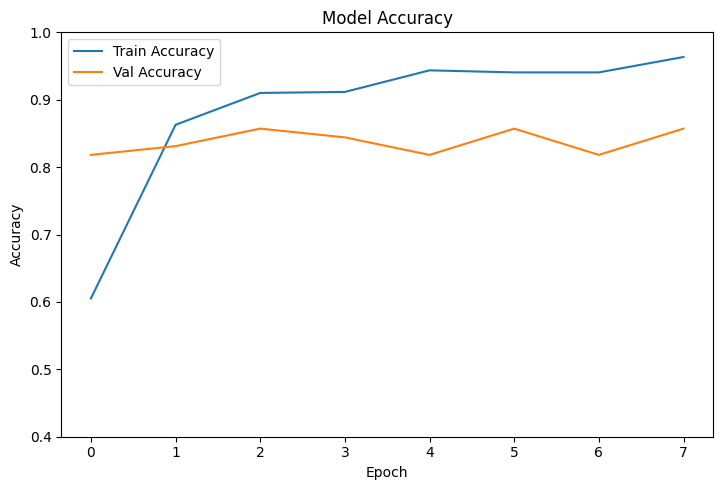

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.40, 1.0)
plt.legend()

plt.tight_layout()
plt.show()


## 10. Classify local image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


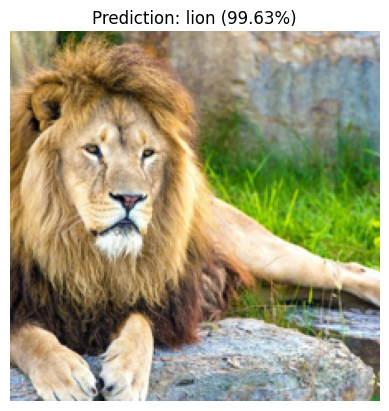

In [26]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((224, 224))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0]
        class_index = np.argmax(prediction)
        confidence = np.max(prediction)
        label = list(train_generator.class_indices.keys())[class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# Example usage (replace with your actual image path)
classify_local_image('/content/raw_data/mammals/lion/00000002.jpg')